# Introduction To Computer Vision Project

## 1. Defining the Question

### Background Information

Good Seed supermarket chain would like to find out whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol.

### Problem Statement

You have been asked to build and evaluate a model for verifying people's age.

### Metric for Success

We will use the MAE as the metric of success, with < 6 as success.

### Solutin Steps
* Load libraries 
* Load data.
* Data exploration.
* Data preparation.
* Data modeling & validation.
* Summarize findings.
* Provide recommendations.
* Challenge the solution.

## 2. Load Libraries

In [1]:
# import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os # to read files and directory structure
import warnings

In [2]:
warnings.filterwarnings('ignore')

## 3. Load Data

We will download the dataset directly from Kaggle. To do so: -
* Download your Kaggle API Token: Login to Kaggle, Go to Account and scroll down to the API section.
* Click “Create New API Token”, a kaggle.json file will be generated and downloaded to your local machine.
* Upload kaggle.json to your Colab project: one way of doing this is, import files module from google.colab, call upload() to launch a File Upload dialog and select the kaggle.json from your local machine.
* Update KAGGLE_CONFIG_DIR path to the current working directory. You can run !pwd to get the current working directory and assign the value to os.environ['KAGGLE_CONFIG_DIR']

In [3]:
# upload kaggle.json
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
# ensure your Kaggle API key is not readable by other users on this system
!chmod 600 /content/kaggle.json

Get the current working directory and assign the value to os.environ['KAGGLE_CONFIG_DIR']

In [5]:
!pwd

/content


In [6]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [7]:
# download dataset
!kaggle datasets download -d abhikjha/appa-real-face-cropped

 95% 218M/228M [00:02<00:00, 118MB/s]
100% 228M/228M [00:02<00:00, 97.5MB/s]


In [8]:
# unzip dataset downloaded in previous step
!unzip '/content/appa-real-face-cropped.zip' -d '/content'

Streaming output truncated to the last 5000 lines.
  inflating: /content/final_files/final_files/002592.jpg  
  inflating: /content/final_files/final_files/002593.jpg  
  inflating: /content/final_files/final_files/002594.jpg  
  inflating: /content/final_files/final_files/002595.jpg  
  inflating: /content/final_files/final_files/002596.jpg  
  inflating: /content/final_files/final_files/002597.jpg  
  inflating: /content/final_files/final_files/002598.jpg  
  inflating: /content/final_files/final_files/002599.jpg  
  inflating: /content/final_files/final_files/002600.jpg  
  inflating: /content/final_files/final_files/002601.jpg  
  inflating: /content/final_files/final_files/002602.jpg  
  inflating: /content/final_files/final_files/002603.jpg  
  inflating: /content/final_files/final_files/002604.jpg  
  inflating: /content/final_files/final_files/002605.jpg  
  inflating: /content/final_files/final_files/002606.jpg  
  inflating: /content/final_files/final_files/002607.jpg  
  inf

Confirm all images downloaded

In [9]:
images_dir = os.path.join(os.environ['KAGGLE_CONFIG_DIR'], 'final_files/final_files')

In [10]:
images_dir

'/content/final_files/final_files'

In [11]:
num_images = len(os.listdir(images_dir))
num_images

7591

Load labels

In [12]:
labels = pd.read_csv('/content/labels.csv')

## 3. Data Exploration

In [13]:
# view a sample of the labels
labels.sample(4)

,file_name,real_age
3375,003375.jpg,16
4241,004241.jpg,19
3191,003191.jpg,55
6256,006260.jpg,25


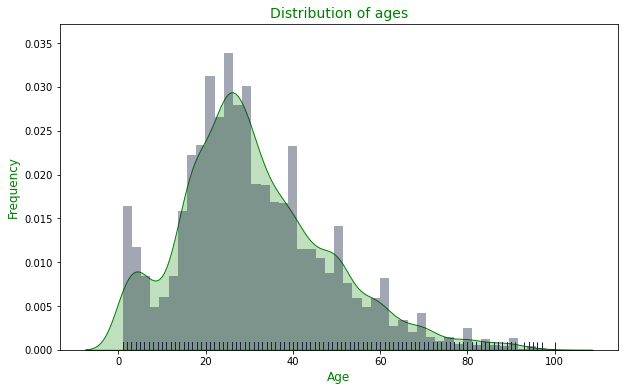

In [14]:
# age distribution
plt.figure(figsize=(10, 6))
sns.set_palette('cubehelix')
sns.distplot(labels['real_age'], rug=True, kde_kws={'shade':True, 'color':'g'})
plt.xlabel('Age', fontsize=12, color='g')
plt.ylabel('Frequency', fontsize=12, color='g')
plt.title('Distribution of ages', fontsize=14, color='g')
plt.show()

From the above graph, majority of ages are between 16 - 45. 

In [15]:
BATCH_SIZE = 32
IMG_SHAPE  = 224

# set up our image generator
image_gen = ImageDataGenerator(rescale=1./255)

images_data_gen = image_gen.flow_from_dataframe(
    dataframe = labels,
    directory = images_dir,
    target_size = (IMG_SHAPE, IMG_SHAPE), # all images need to be of the same pixel size
    batch_size = BATCH_SIZE, # load images batch by batch (every time 32 images will be loaded)
    seed = 12345,
    x_col = "file_name", 
    y_col = "real_age",
    class_mode = "raw", # raw because we are doing regression
    # shuffle = True,
    )

Found 7591 validated image filenames.


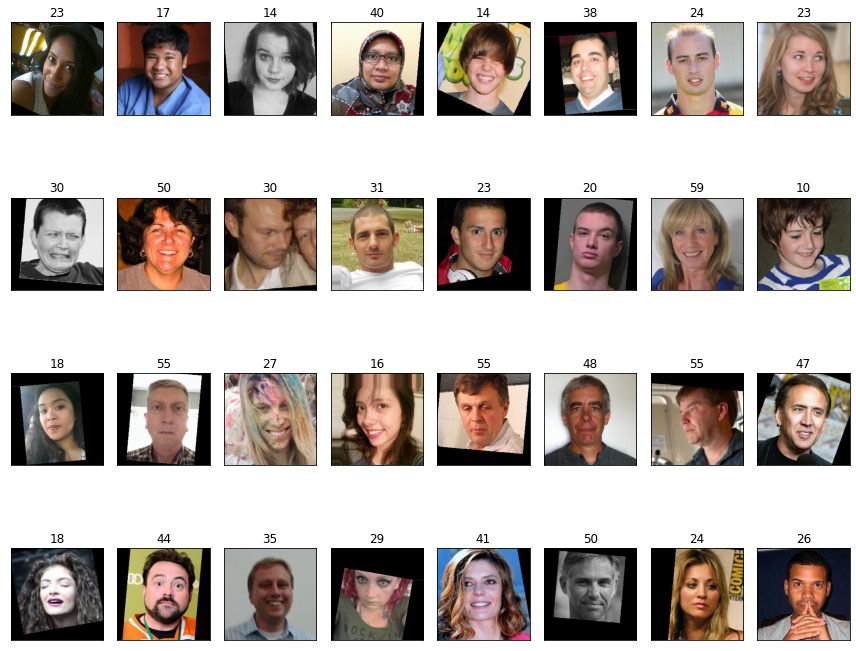

In [19]:
# let's have a look at one batch (32 images) from our data generator
features, target = next(images_data_gen)

fig = plt.figure(figsize=(12,12))
for i in range(32):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(features[i])
    plt.title(f'{target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## 4. Data Preparation

Helper Functions

In [20]:
def load_train_data(path, img_shape, batch_size):
    labels = pd.read_csv(path + 'labels.csv')
    images_gen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255)
    train_data_gen = images_gen.flow_from_dataframe(
        directory = path + 'final_files/final_files/',
        dataframe = labels,
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (img_shape, img_shape),
        batch_size = batch_size,
        class_mode = 'raw',
        subset = 'training',
        seed=12345
    )

    return train_data_gen

In [21]:
def load_test_data(path, img_shape, batch_size):
    labels = pd.read_csv(path + 'labels.csv')
    data_gen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    test_data_gen = data_gen.flow_from_dataframe(
      dataframe = labels,
      directory = path +'final_files/final_files/',
      x_col = "file_name",
      y_col = "real_age", 
      class_mode = "raw", 
      target_size = (img_shape, img_shape),
      batch_size = batch_size,
      subset = "validation",
      seed=12345,
    )

    return test_data_gen

In [23]:
def create_model(input_shape):
    # we will use ResNet50 architecture
    backbone = ResNet50(input_shape = input_shape, weights = 'imagenet', include_top=False)

    # freeze ResNet50 to avoid  overtraining
    backbone.trainable = False
    
    model = Sequential()
    model.add(backbone)
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    model.compile(optimizer = 'adam', loss='mae', metrics=['mae'])
    print(model.summary())

    return model

In [24]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20, steps_per_epoch=None, validation_steps=None):
    
    model.fit(
        train_data, 
        validation_data = test_data,
        batch_size = batch_size, 
        epochs = epochs, 
        steps_per_epoch = steps_per_epoch, 
        validation_steps = validation_steps, 
        verbose = 2
        )

    return model

Get training & validation data

In [25]:
path = os.environ['KAGGLE_CONFIG_DIR']  + '/'

In [26]:
train_data = load_train_data(path, IMG_SHAPE, BATCH_SIZE)

Found 5694 validated image filenames.


In [27]:
test_data = load_test_data(path, IMG_SHAPE, BATCH_SIZE)

Found 1897 validated image filenames.


## 5. Data Modeling & Validation

In [28]:
model = create_model(input_shape = (IMG_SHAPE, IMG_SHAPE, 3))

94781440/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [29]:
model = train_model(model, train_data, test_data, batch_size=BATCH_SIZE)

Epoch 1/20
178/178 - 1050s - loss: 18.7315 - mae: 18.7315 - val_loss: 12.8301 - val_mae: 12.8301 - 1050s/epoch - 6s/step
Epoch 2/20
178/178 - 1040s - loss: 13.1443 - mae: 13.1443 - val_loss: 12.9360 - val_mae: 12.9360 - 1040s/epoch - 6s/step
Epoch 3/20
178/178 - 1035s - loss: 13.1490 - mae: 13.1490 - val_loss: 12.8745 - val_mae: 12.8745 - 1035s/epoch - 6s/step
Epoch 4/20
178/178 - 1034s - loss: 13.1371 - mae: 13.1371 - val_loss: 12.9041 - val_mae: 12.9041 - 1034s/epoch - 6s/step
Epoch 5/20
178/178 - 1033s - loss: 13.1396 - mae: 13.1396 - val_loss: 12.8627 - val_mae: 12.8627 - 1033s/epoch - 6s/step
Epoch 6/20
178/178 - 1034s - loss: 13.1352 - mae: 13.1352 - val_loss: 13.0118 - val_mae: 13.0118 - 1034s/epoch - 6s/step
Epoch 7/20
178/178 - 1030s - loss: 13.1410 - mae: 13.1410 - val_loss: 12.8422 - val_mae: 12.8422 - 1030s/epoch - 6s/step
Epoch 8/20
178/178 - 1039s - loss: 13.1376 - mae: 13.1376 - val_loss: 12.9296 - val_mae: 12.9296 - 1039s/epoch - 6s/step
Epoch 9/20
178/178 - 1042s - los

## 7. Summary of Findings

Our model has a mean absolute error (MAE) that's not quite good, it can predict the age of a person with  ±  12.9

## 8. Recommendation
I recommend training the model further with more trainable parameters or try different algorithms.

## 9. Challenging the Solution
Did we have the right question? Yes

Did we have the right data? Yes

How can we improve the solution?

> The following ways can be used to improve our model's MAE:
* Train ResNet from scratch (weights=None)
* Use more trainable parameters
* Experiment with different learning rates
* Add more layers


